### Calcolo funzioni di autocorrelazione mediando su tutto il database (separatamente per ogni rho) più calcolo std

$$ 
acf(k) = \sum_{n=0}^{N-k-1} a(n)\,\,\, a(n+k)
$$

a(n) per n da 0 a N-1 e acf(k) per k da 0 a N-1. Poi ognuna la normalizzo rispetto al suo massimo, in modo che partano sempre da 1.

In [ ]:
import numpy as np
    
def acf(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:] / result[result.size // 2:].max()

def compute_acfs(paths):
    aaacf = np.ndarray(shape=(2,3,2000))
    for path in paths:
        r = float(path[-8:-4])
        print(f'computing acf for r={r}', end=' ')
        db = np.load(path)
        sig_len = len(db[0,0,:])
        n_traj = len(db[:,0,0])
        aacf = np.ndarray(shape=(n_traj,3,sig_len))
        aacf[:,:,:] = 0.0
        for traj, ii in zip(db, range(n_traj)):
            a = traj[0,:]
            b = traj[1,:]
            c = traj[2,:]
            a -= np.mean(a)
            b -= np.mean(b)
            c -= np.mean(c)
            aacf[ii,0,:] = acf(a)
            aacf[ii,1,:] = acf(b)
            aacf[ii,2,:] = acf(c)
        
        aaacf[:,:,:] = 0.0
        aaacf[0,:,:] = np.mean(aacf, axis=0)
        aaacf[1,:,:] = np.std(aacf, axis=0)   
        np.save(f'/scratch/scarpolini/databases/acfe_lorenz_{r:.1f}', aaacf)
        print('Saved!')

def load_acf(r):
    path = f'/scratch/scarpolini/databases/acfe_lorenz_{r:.1f}.npy'
    acf = np.load(path)
    return acf

def load_random_traj(r):
    n = round(np.random.uniform(50000))
    path = f'/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy'
    trajx = np.load(path)[n,0,:]
    return trajx

import glob
paths = glob.glob('/scratch/scarpolini/databases/db_lorenz_*.npy')
paths = sorted(paths, key=lambda x : float(x[-8:-4]))
path = paths[1:2]
compute_acfs(path)

### plotto risultati acf e std per una rho

In [ ]:
def plot_acfs(rv, xlim):
    import matplotlib.pyplot as plt
    for r in rv:
        mm = load_acf(r)[0,0,:]
        ss = load_acf(r)[1,0,:]
        l, caps, c = plt.errorbar(range(xlim),mm[:xlim],yerr=ss[:xlim], lw=0, marker='o', ms=6,
                                  elinewidth=1, uplims=True, lolims=True, capsize=5, label=str(r))
        for cap in caps:
            cap.set_marker("_")
        plt.xlabel("t")
        plt.ylabel("acf")
    plt.title('auto corr func')
    plt.legend()
    plt.show()

plot_acfs([10, 46],30)

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


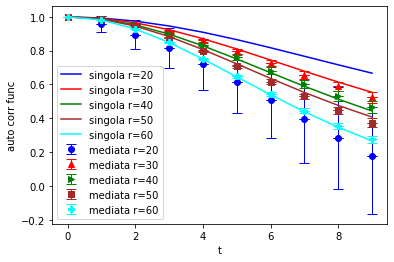

In [88]:
import numpy as np
import matplotlib.pyplot as plt

xlim = 10
rv = [20,30,40, 50, 60]
markers = ['o', '^', '>', 's', 'P', '*']
colors = ['blue', 'red', 'green', 'brown', 'cyan', 'purple']
### mediati
for i, r in enumerate(rv) :
    pathh = f'/scratch/scarpolini/databases/acfe_lorenz_{r:.1f}.npy'
    aacf = load_acf(r)[0,0,:]
    acfe = load_acf(r)[1,0,:]
    l, caps, c = plt.errorbar(range(xlim),aacf[:xlim],yerr=acfe[:xlim], label='mediata r='+str(r), lw=0, c=colors[i], 
                              marker=markers[i], ms=6, elinewidth=1, uplims=True, lolims=True, capsize=5)
    for cap in caps:
        cap.set_marker("_")

### traiettorie singole
for i, r in enumerate(rv) :
    trajx = load_random_traj(r)
    acfx = acf(trajx)
    plt.plot(range(xlim),acfx[:xlim], label='singola r='+str(r), c=colors[i])
        
plt.xlabel("t")
plt.ylabel("auto corr func")
plt.legend()
plt.savefig(f'plots/acf_comparation{rv}.png', dpi=220, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)
plt.show()

### Exit time $\bar{t}_s$
$$
\bar t _s := \bar t \quad t.c. \quad acf(\bar t) = s
$$

In [1]:
import numpy as np
    
def acf(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:] / result[result.size // 2:].max()

def exit_time(paths, soglia):
    for jj, path in enumerate(paths):
        etx = []
        ety = []
        etz = []
        r = float(path[-8:-4])
        print(f'computing exit time for r={r}, {0:5}', end='\r')
        db = np.load(path)
        sig_len = len(db[0,0,:])
        n_traj = len(db[:,0,0])
        for traj, ii in zip(db, range(n_traj)):
            if ii == 49999: print(f'computing exit time for r={r}, {ii:5}', end=' ')
            else: print(f'computing exit time for r={r}, {ii:5}', end='\r')
            a = traj[0,:]
            b = traj[1,:]
            c = traj[2,:]
            a -= np.mean(a)
            b -= np.mean(b)
            c -= np.mean(c)
            acfx = acf(a)
            acfy = acf(b)
            acfz = acf(c)
            for t in range(len(acfx)):
                if acfx[t] < soglia :
                    etx.append((1.)/(acfx[t]-acfx[t-1])*(0.5-acfx[t-1]) + t - 1.) ### interpolazione lineare
                    break
            for t, y in enumerate(acfy):
                if y < soglia :
                    ety.append(t)
                    break
            for t, y in enumerate(acfz):
                if y < soglia :
                    etz.append(t)
                    break
        np.save(f'/scratch/scarpolini/databases/exit_time_{soglia:.2f}_lorenz_{r:.1f}', [etx])
        print('Saved!')
        
        
def gen_exit_time(paths, soglia):
    for jj, path in enumerate(paths):
        etx = []
        # r = float(path[-8:-4])
        r = 54
        print(f'computing exit time for r={r}, {0:5}', end='\r')
        db = np.load(path)
        sig_len = len(db[0,:,0])
        n_traj = len(db[:,0,0])
        for traj, ii in zip(db, range(n_traj)):
            if ii == 49999: print(f'computing exit time for r={r}, {ii:5}', end=' ')
            else: print(f'computing exit time for r={r}, {ii:5}', end='\r')
            a = traj[:,0]
            a -= np.mean(a)
            acfx = acf(a)
            for t in range(len(acfx)):
                if acfx[t] < soglia :
                    etx.append((1.)/(acfx[t]-acfx[t-1])*(0.5-acfx[t-1]) + t - 1.) ### interpolazione lineare
                    break
        np.save(f'/scratch/scarpolini/databases/gen_exit_time_{soglia:.2f}_lorenz_{r:.1f}', [etx])
        print('Saved!')

def load_acf(r):
    path = f'/scratch/scarpolini/databases/acfe_lorenz_{r:.1f}.npy'
    acf = np.load(path)
    return acf

def load_random_traj(r):
    n = round(np.random.uniform(50000))
    path = f'/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy'
    trajx = np.load(path)[n,0,:]
    return trajx

import glob
paths = glob.glob('/scratch/scarpolini/databases/db_lorenz_*.npy')
paths = sorted(paths, key=lambda x : float(x[-8:-4]))
path = paths
#exit_time(path,0.5, mode=1)

In [2]:
path = ['../lorenz_wgan/runs/9/gen_trajs.npy']
gen_exit_time(path,0.5)


computing exit time for r=54, 49999 Saved!


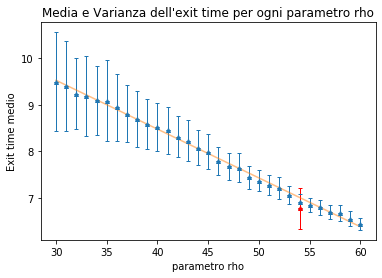

In [8]:
import matplotlib.pyplot as plt
import numpy as np

soglia = 0.5

rv = range(30,61,1)
paths = [f'/scratch/scarpolini/databases/exit_time_{soglia:.2f}_lorenz_{r:.1f}.npy' for r in rv]
gen_path = '/scratch/scarpolini/databases/gen_exit_time_0.50_lorenz_54.0.npy'
et = [np.load(path) for path in paths]

labels = [str(r) for r in rv]
means = [np.mean(x) for x in [x[0] for x in et]]
stds = [np.std(x) for x in [x[0] for x in et]]

gen = np.load('/scratch/scarpolini/databases/gen_exit_time_0.50_lorenz_54.0.npy')
gen_mean, gen_std = np.mean(gen), np.std(gen)


l, caps, c = plt.errorbar(rv, means, stds, lw=0, marker='^', ms=4, elinewidth=1, uplims=True, lolims=True, capsize=2)
for cap in caps:
    cap.set_marker("_")

l, caps, c = plt.errorbar([54.0], gen_mean, gen_std, lw=0, marker='^', ms=4, color='red', elinewidth=1, uplims=True, lolims=True, capsize=2)
for cap in caps:
    cap.set_marker("_")    

plt.plot(rv, fit, alpha = 0.5)
plt.xlabel('parametro rho')
plt.ylabel('Exit time medio')
plt.title("Media e Varianza dell'exit time per ogni parametro rho")
#plt.savefig("plots/exit_time_medio.png", dpi=220, format='png')
plt.show()


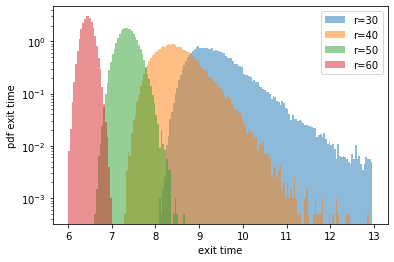

In [152]:
import matplotlib.pyplot as plt

soglia = 0.5

rv = range(30,70,10)
labels = ['r='+str(r) for r in rv]
paths = [f'/scratch/scarpolini/databases/exit_time_{soglia:.2f}_lorenz_{r:.1f}.npy' for r in rv]
for path, label in zip(paths, labels):
    plt.hist(np.load(path)[0], bins=np.arange(6,13,0.04), density=True, alpha=0.5, label=label)

plt.xlabel('exit time')
plt.ylabel('pdf exit time')
plt.yscale('log')
plt.legend()
plt.savefig("plots/pdf_exit_time.png", dpi=220, format='png')
plt.show()

### faccio il fit tramite una retta dell'exit time in funzione del parametro rho

In [6]:
from scipy.optimize import curve_fit

def retta(x, a, b):
    return a*x + b

rvv = np.array(range(30,70,10))
a, b = curve_fit(retta, rv, means)



In [7]:
fit = retta(rv, a=a[0], b=a[1])
def inversa(y):
    return (1./a[0])*y - a[1]/a[0]

## ora carico tutti gli exit time calcolati per un certo rho e faccio le previsioni in base al fit inverso

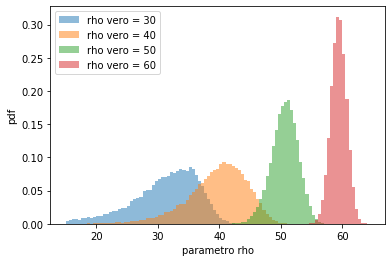

In [46]:
rv = [30, 40, 50, 60]
labels = ['rho vero = '+str(r) for r in rv]
for r, label in zip(rv, labels):
    path = f'/scratch/scarpolini/databases/exit_time_{0.5:.2f}_lorenz_{r:.1f}.npy'
    et = np.load(path)
    previsione = inversa(et[0])
    plt.hist(previsione, bins=np.arange(15,65,0.5), density=True, alpha=0.5, label=label)

plt.xlabel('parametro rho')
plt.ylabel('pdf')
plt.legend()
plt.savefig("plots/pdf_exit_time_predictions.png", dpi=220, format='png')
plt.show()

In [15]:
gen = np.load('/scratch/scarpolini/lorenz_wgan/runs/9/gen_trajs.npy').reshape(50000,2000)
et_gen = np.load('/scratch/scarpolini/databases/gen_exit_time_0.50_lorenz_54.0.npy').reshape(50000)
inv_et_gen = inversa(et_gen)

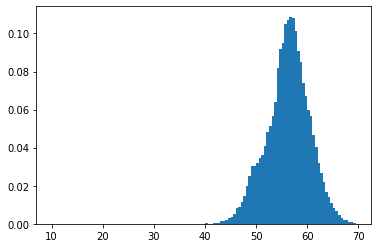

In [16]:
plt.hist(inv_et_gen, bins=np.arange(10,70,0.5), density=True)
plt.show()

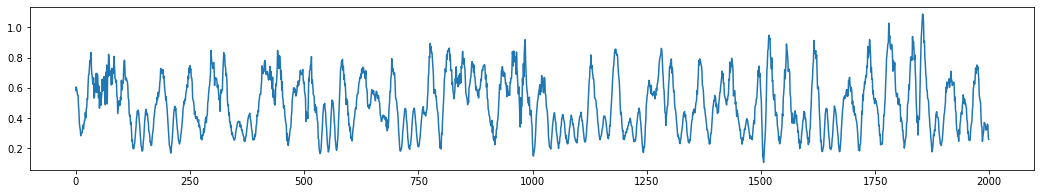

In [17]:
plt.figure(figsize=(18,3))
plt.plot(gen[0,:])
plt.show()